# 📘 Task Overview

This notebook presents a solution to a binary classification task with **paired text samples**.

## 📊 Dataset Summary
- **Training set**: 95 examples  
- **Test set**: 1,068 examples  
- Each sample contains **two texts** (`text1` and `text2`), one is **real**, the other is **fake**.
- The order of texts is randomized; the real one can appear first or second.

## 🎯 Objective
Build a model to **predict which text is real** for each pair in the test set.  
The **evaluation metric** is **pairwise accuracy** — whether the predicted real text matches the ground truth.

## 🧪 Workflow Summary

1. **Text Encoding**:  
   Use a pretrained **BERT model** to extract vector representations for both `text1` and `text2`.

2. **Feature Construction**:  
   Concatenate the following features:
   - `vec1` (embedding of `text1`)
   - `vec2` (embedding of `text2`)
   - `vec1 - vec2` (difference)
   - `vec1 * vec2` (element-wise product)

3. **Dimensionality Reduction**:  
   Apply **PCA** to reduce the high-dimensional BERT feature space (e.g., to 20 dimensions).

4. **Model Training**:  
   Fit traditional machine learning models on the reduced features, including:
   - XGBoost
   - CatBoost
   - SVM
   - Random Forest  
   ...and evaluate their performance.

5. **Prediction**:  
   Predict whether `text1` is the real text for each test pair.

6. **Evaluation**:  
   Measure **pairwise accuracy** as the final performance metric.

---

# Libraries

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import re
from datasets import Dataset
from datasets import DatasetDict
from transformers import AutoTokenizer,AutoModel
import torch
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import xgboost as xgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("fast") 

/Users/shaemckenna/Programs/real_or_fake/rof/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 📂 LoadDataset

---

This section prepares the data for model training and inference.  
It includes custom generators to handle the specific folder-based dataset format.

1. **Build the training sample generator**  
   - For each pair of texts, determine the label:  
     `label = 1` if `text1` is the real/original text.

2. **Build the test sample generator**  
   - Load text pairs without labels (used for final prediction).

3. **Wrap datasets using HuggingFace's `Dataset` and `DatasetDict`**  
   - Construct `train_dataset` and `test_dataset` from generators.  
   - Store them in a `DatasetDict` named `raw_datasets` for downstream processing.

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


In [3]:
def train_data_generator(data_dir, csv_path):
    """
    Yield dictionaries of (text1, text2, label) for training.
    Label = 1 if file_1.txt is the real/original text, else 0.
    """
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        folder_id = row["id"]
        real_text_id = row["real_text_id"]

        folder_path = os.path.join(data_dir, f"article_{folder_id:04d}")
        file1_path = os.path.join(folder_path, "file_1.txt")
        file2_path = os.path.join(folder_path, "file_2.txt")

        with open(file1_path, encoding="utf-8") as f1:
            text1 = f1.read()
        with open(file2_path, encoding="utf-8") as f2:
            text2 = f2.read()

        label = 1 if real_text_id == 1 else 0

        yield {
            "id": folder_id,
            "text1": text1,
            "text2": text2,
            "label": label
        }

In [4]:
def test_data_generator(data_dir):
    """
    Yield dictionaries of (text1, text2) for testing (no labels).
    """
    folders = sorted([
        f for f in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, f)) and re.match(r'article_\d+', f)
    ])

    for folder in folders:
        folder_id = int(folder.split('_')[1])
        folder_path = os.path.join(data_dir, folder)

        file1_path = os.path.join(folder_path, "file_1.txt")
        file2_path = os.path.join(folder_path, "file_2.txt")

        with open(file1_path, encoding="utf-8") as f1:
            text1 = f1.read()
        with open(file2_path, encoding="utf-8") as f2:
            text2 = f2.read()

        yield {
            "id": folder_id,
            "text1": text1,
            "text2": text2
        }

In [5]:
# Paths
train_dir = "../data/train"
train_csv = "../data/train.csv"
test_dir = "../data/test"

# Create datasets from generators
train_dataset = Dataset.from_generator(lambda: train_data_generator(train_dir, train_csv))
test_dataset = Dataset.from_generator(lambda: test_data_generator(test_dir))

# Combine into a DatasetDict
raw_datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

Generating train split: 95 examples [00:00, 4433.63 examples/s]
Generating train split: 1068 examples [00:00, 8868.59 examples/s]


In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'text1', 'text2', 'label'],
        num_rows: 95
    })
    test: Dataset({
        features: ['id', 'text1', 'text2'],
        num_rows: 1068
    })
})

# 🧠 BERT Feature Extraction

---

This section uses a pretrained **BERT model** to extract dense vector representations from input texts.  
Since texts may exceed BERT’s maximum token length (typically 512), I apply **sliding window chunking** and compute **mean-pooled embeddings** across chunks.

## 🧾 Method: `extract_mean_pooling_vector`

In [10]:
def extract_mean_pooling_vector(text, tokenizer, model, max_len=512, stride=256, device="cpu"):
    """
    Extracts a mean-pooled vector for a potentially long input text using sliding windows.
    - Handles token overflow via `stride`
    - Removes padding effects via attention mask
    - Returns a single average vector across all chunks
    """
    encoded = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_len,
        stride=stride,
        return_overflowing_tokens=True,
        padding="max_length"
    )

    input_ids_chunks = encoded["input_ids"]
    attention_mask_chunks = encoded["attention_mask"]

    all_mean_vecs = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for input_ids, attention_mask in zip(input_ids_chunks, attention_mask_chunks):
            input_ids = input_ids.unsqueeze(0).to(device)
            attention_mask = attention_mask.unsqueeze(0).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state  # shape: [1, seq_len, hidden_dim]

            # Apply mean pooling (excluding padded tokens)
            mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
            masked_hidden = last_hidden_state * mask
            summed = masked_hidden.sum(dim=1)
            count = mask.sum(dim=1)
            mean_vec = summed / count

            all_mean_vecs.append(mean_vec.squeeze(0))

    # Average over all chunks to form the final vector
    final_vec = torch.stack(all_mean_vecs).mean(dim=0)

    return final_vec.cpu()

## Load Pretrained BERT Model

In [8]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bert_model = AutoModel.from_pretrained(model_checkpoint, num_labels=2)

In [11]:
#Test on a Sample Text
text = raw_datasets['train'][0]["text1"]
vector = extract_mean_pooling_vector(text, tokenizer, bert_model)
print(vector.shape)

torch.Size([768])


# 🧬 Feature Extraction and Interaction Construction

---

This section extracts vector representations from paired texts using a BERT model and constructs interaction-based features. The resulting vectors are then reduced in dimensionality via PCA for use in traditional machine learning models.

## 🔗 Feature Construction Strategy

For each input pair:

- `vec1`: mean-pooled BERT embedding of `text1`
- `vec2`: mean-pooled BERT embedding of `text2`

Interaction features are computed as follows:

- `diff` = `vec1 - vec2` (semantic difference)
- `prod` = `vec1 * vec2` (element-wise interaction)

These are concatenated with the original vectors:

> Final feature vector = `[vec1, vec2, vec1 - vec2, vec1 * vec2]`  
> Total dimensionality = 4 × hidden_size (e.g., 4 × 768 = 3072 for BERT-base)

---

## ⚙️ Feature Extraction Function

In [12]:
def extract_features(dataset, tokenizer, model):
    """
    Extracts interaction-based features from each text pair.

    Returns:
        features: numpy array of shape [num_samples, feature_dim]
        ids: list of sample IDs
    """
    features = []
    ids = []

    for row in tqdm(dataset, desc="Extracting features"):
        vec1 = extract_mean_pooling_vector(row['text1'], tokenizer, model)
        vec2 = extract_mean_pooling_vector(row['text2'], tokenizer, model)

        # Compute interaction vectors
        diff = vec1 - vec2
        prod = vec1 * vec2

        # Concatenate all parts
        final_vec = torch.cat([vec1, vec2, diff, prod])
        features.append(final_vec.numpy())
        ids.append(row['id'])

    return np.array(features), ids

# ⚙️ Apply: Feature Extraction and Preprocessing
---

This section extracts features from both training and test datasets using the BERT-based vector encoder and constructs interaction features. Dimensionality is reduced using PCA, and the resulting vectors are prepared for downstream machine learning models.

In [13]:
# Extract raw features from training datasets
X_train_raw, train_ids = extract_features(raw_datasets["train"], tokenizer, bert_model)

Extracting features: 100%|██████████| 95/95 [00:59<00:00,  1.61it/s]


In [14]:
# Step 2: Apply PCA (fit only on training set)
n_components = 20
pca_model = PCA(n_components=n_components)

# Fit on training features only
X_train = pca_model.fit_transform(X_train_raw)

# Step 3: Extract labels
y_train = np.array([ex["label"] for ex in raw_datasets["train"]])

# 🧪 Traditional Machine Learning Evaluation

---

This section evaluates multiple traditional classifiers on the BERT-derived feature representations using 5-fold stratified cross-validation. Evaluation metrics include Accuracy, Precision, Recall, and F1-score. A bar chart is plotted to compare the models visually.

---

## 🔧 Step 1: Define Classifiers

In [15]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

## 🔁 Step 2: Cross-Validation Evaluation

In [16]:
# Use stratified 5-fold cross-validation to preserve label balance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    # Store metrics across folds
    accuracies, precisions, recalls, f1s = [], [], [], []

    # 5-fold CV loop
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Train model and predict
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Compute metrics
        acc = accuracy_score(y_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average='macro'
        )

        # Append metrics
        accuracies.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    # Average metrics across folds
    results[name] = {
        "Accuracy": np.mean(accuracies),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-score": np.mean(f1s)
    }

/Users/shaemckenna/Programs/real_or_fake/rof/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shaemckenna/Programs/real_or_fake/rof/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shaemckenna/Programs/real_or_fake/rof/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shaemckenna/Programs/real_or_fake/rof/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:26:30] WARNING: /Users/runner/work/

## 📊 Step 3: Summary Table and Visualization

In [17]:
# Create DataFrame and sort by F1-score
df_results = pd.DataFrame(results).T.sort_values(by="F1-score", ascending=False).round(4)
print(df_results)

                    Accuracy  Precision  Recall  F1-score
LogisticRegression    0.8316     0.8341  0.8313    0.8300
SVM                   0.8316     0.8451  0.8220    0.8227
CatBoost              0.7895     0.8020  0.7831    0.7811
RandomForest          0.7789     0.7863  0.7767    0.7754
XGBoost               0.7263     0.7277  0.7227    0.7211


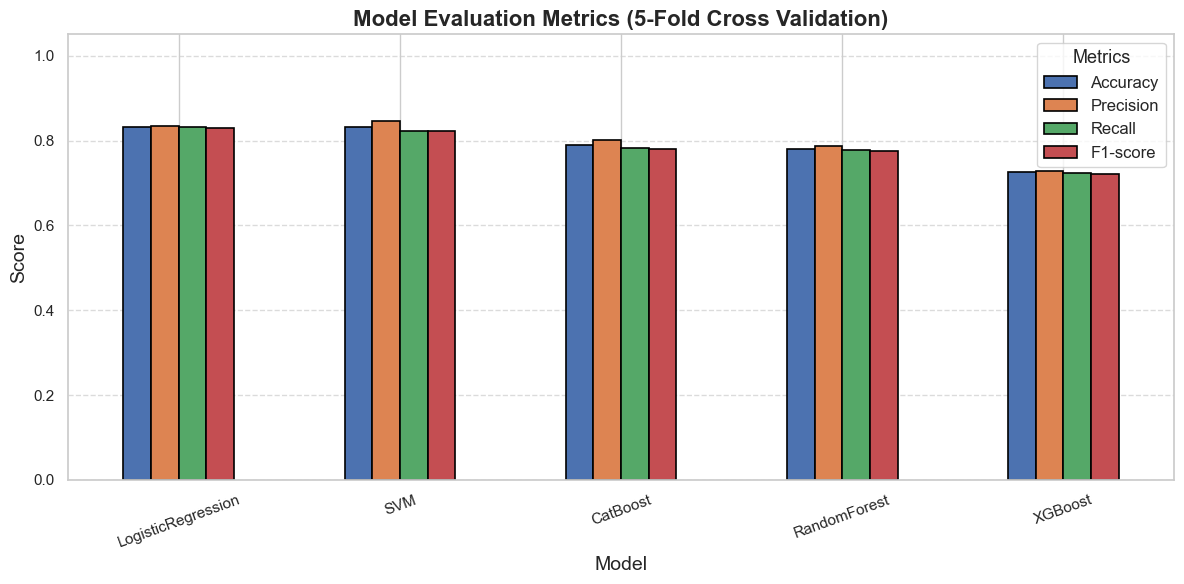

In [18]:
# Set visualization style
sns.set(style="whitegrid")

# Create grouped bar chart
ax = df_results.plot(
    kind="bar",
    figsize=(12, 6),
    edgecolor='black',
    linewidth=1.2
)

# Set titles and labels
ax.set_title("Model Evaluation Metrics (5-Fold Cross Validation)", fontsize=16, weight='bold')
ax.set_ylabel("Score", fontsize=14)
ax.set_xlabel("Model", fontsize=14)

# Adjust ticks and grid
plt.xticks(rotation=20)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend formatting
plt.legend(title="Metrics", fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

# 🧾 Final Prediction and Submission
---

This section uses the best-performing classifier to predict on the test set and generates a submission file in the required format. The goal is to identify which of the two texts in each test sample is the real one (`real_text_id ∈ {1, 2}`).

---

## 🔮 Step 1: Extract and Transform Test Features

In [19]:
# Extract raw interaction features from test set
X_test_raw, test_ids = extract_features(raw_datasets["test"], tokenizer, bert_model)

# Use previously fitted PCA model to transform test features
X_test = pca_model.transform(X_test_raw)

Extracting features: 100%|██████████| 1068/1068 [08:35<00:00,  2.07it/s]


## 🥇 Step 2: Select and Train Best Model

In [27]:
# Select the best model based on F1-score from cross-validation
best_model_name = df_results.index[3]
best_model = models[best_model_name]

# Retrain the best model on the entire training set
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 📈 Step 3: Predict Real Text in Each Test Pair

In [28]:
# Predict probability that text1 is the real one
test_probs = best_model.predict_proba(X_test)[:, 1]  # probability of class '1'

## 📤 Step 4: Construct Submission File
- If prob ≥ 0.5: predict text1 is real → real_text_id = 1
- Else: text2 is predicted as real → real_text_id = 2

In [29]:
submission = []

# Loop through test IDs and assign predicted label
for i, pid in enumerate(test_dataset["id"]):
    prob = test_probs[i]
    real_text_id = 1 if prob >= 0.5 else 2
    submission.append((pid, real_text_id))

# Convert to DataFrame and export as CSV
submission_df = pd.DataFrame(submission, columns=["id", "real_text_id"])
submission_df.to_csv("submission.csv", index=False)

# Preview submission
print(submission_df.head())

   id  real_text_id
0   0             1
1   1             1
2   2             2
3   3             2
4   4             1
